# Ford GoBike System Data
## by Murong (Sophie) Cui


[Introduction](#1)<br>
[Data Wrangling](#2)
 - [Data Assessing and Cleaning](#2.1)
 - [Feature engineering](#2.2)

[Geo Analysis](#3)
 - [Station](#3.1)
 - [Path](#3.2)

[Univariate Exploration](#4)<br>
[Bivariate Exploration](#5)<br>
[Multivariate Exploration](#6)<br>


<a id ='1'></a>
## Introduction

> This data set includes information about individual rides made
in a bike-sharing system covering the greater San Francisco
Bay area.

> Note that this dataset will require some data wrangling in
order to make it tidy for analysis.



### What is the structure of your dataset?

> There are 174,951 rows represting 174951 rides during Feb 2019 in Great San Francisco (San Francisco, Oakland, San Jose) and 15 columns

- Trip Duration (seconds)
- Start Time and Date
- Stop Time and Date
- Start Station ID
- Start Station Name
- Start Station Latitude
- Start Station Longitude
- End Station ID
- End Station Name
- End Station Latitude
- End Station Longitude
- Bike ID
- User Type (Customer = 24-hour pass or 3-day pass user; Subscriber = Annual Member)
- Gender (Other; Male; Female)
- Year of Birth
- bike_share_for_all_trip, which tracks members who are enrolled in the Bike Share for All program for low-income residents.

### What is/are the main feature(s) of interest in your dataset?

> Gobike completed close to 200 thousand rides in San Francisco in one month (Fed 2019), which shows us a great need of short/medium bike transportation. So firstly, we could look at the popularity of stations and paths that may could help making business decision like where to add a station or add more bikes at certain station.
Secondly, we could also take a look at the customer segmentation. We have some user feature like, age, gender, subscribed or not, in the program 'bike share for all' or not ...<br>
Then, it is interesting to draw insights from share-mobility over time. But since we only have one month data, it is still worthy to take a look at the trip frequency by day of the week, or the hour of the day, etc....<br>

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

> Trip Duration, Start/End Time and Date, Latitude and Longitude, User Type, Gender, Year of Birth, bike share for all trip...

In [51]:
# import all packages and set plots to be embedded inline
import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
sb.set_context("paper")
%matplotlib inline

In [52]:
import folium
from folium.plugins import MarkerCluster
import geopandas as gpd 
from datetime import datetime
import missingno as msno


In [53]:
from PIL import Image, ImageDraw, ImageFont
import matplotlib.colors
from matplotlib.colors import LinearSegmentedColormap, rgb_to_hsv, hsv_to_rgb
import scipy.ndimage.filters

In [54]:
gb = pd.read_csv('201902-fordgobike-tripdata.csv')

<a id='2'></a>
## Data Wrangling

<a id='2.1'></a>
### Data Assessing and Cleaning
1. Data Type:<br>
The datatype of `start_time` and `stop_time` is object, we convert them to datetime<br>
The datatype of `start_station_id`, `end_station_id` and `bike_id` should be changed to integer.<br>
2. 197 missing values on `start_station_name`, `start_station_id`, `end_station_name`, `end_station_id`<br>:
After taking a subset dataset only contains these missing values, I found the station with latitude -37.40, and longitude -121.94 having missing name and ID. And the rides with missing station name and ID share the same coordinates of start station and end station and mostly have duration less than 20 minutes, which it gives us the portfolio for these rides are short trips while starting and ending at the same location.<br>
So I check the station map https://account.baywheels.com/map (Ford Gobike was operated by BayWheel since June, 2019) and these is no bike station around (-37.40, -121.94), which indicated that the station is no more here now, therefore I could not impute the name and ID for this bike station.<br>
Finally, we drop these rows. But if this was a work project, I would likely reach out to the company to double check.<br>
3. Erroneous value on `member_birth_year`<br>
The minimum value of member_birth_year is 1878, which represent age 141 in 2019. The record will be dropped. 


(183412, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183412 entries, 0 to 183411
Data columns (total 16 columns):
duration_sec               183412 non-null int64
start_time                 183412 non-null object
end_time                   183412 non-null object
start_station_id           183215 non-null float64
start_station_name         183215 non-null object
start_station_latitude     183412 non-null float64
start_station_longitude    183412 non-null float64
end_station_id             183215 non-null float64
end_station_name           183215 non-null object
end_station_latitude       183412 non-null float64
end_station_longitude      183412 non-null float64
bike_id                    183412 non-null int64
user_type                  183412 non-null object
member_birth_year          175147 non-null float64
member_gender              175147 non-null object
bike_share_for_all_trip    183412 non-null object
dtypes: float64(7), int64(2), object(7)
memory usage: 22.4+ MB
None
dur

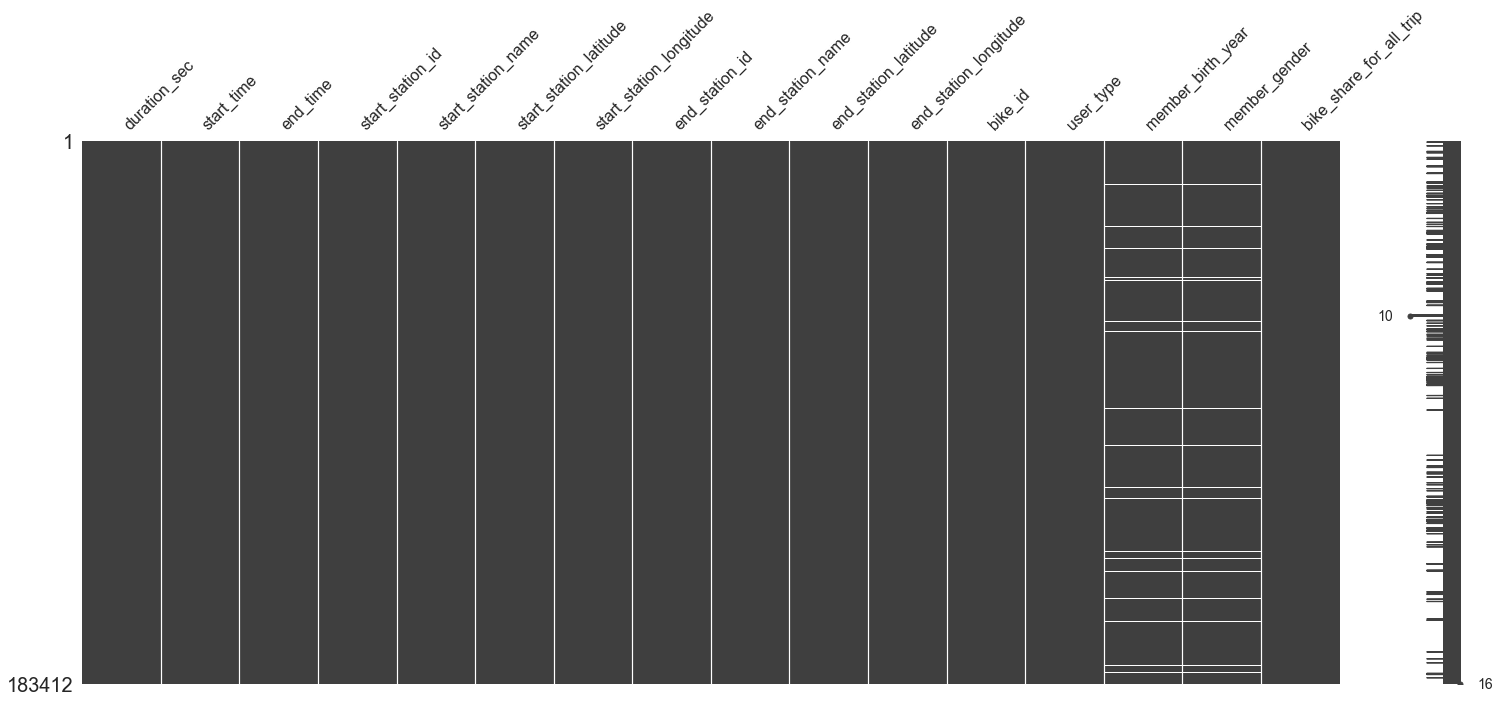

In [55]:
# check data shape and data type
# look at the missing value
print(gb.shape)
print(gb.info())
print(gb.isnull().sum())
msno.matrix(gb)

In [56]:
# check numeric variables
print(gb.describe())

        duration_sec  start_station_id  start_station_latitude  \
count  183412.000000     183215.000000           183412.000000   
mean      726.078435        138.590427               37.771223   
std      1794.389780        111.778864                0.099581   
min        61.000000          3.000000               37.317298   
25%       325.000000         47.000000               37.770083   
50%       514.000000        104.000000               37.780760   
75%       796.000000        239.000000               37.797280   
max     85444.000000        398.000000               37.880222   

       start_station_longitude  end_station_id  end_station_latitude  \
count            183412.000000   183215.000000         183412.000000   
mean               -122.352664      136.249123             37.771427   
std                   0.117097      111.515131              0.099490   
min                -122.453704        3.000000             37.317298   
25%                -122.412408       44.00000

In [57]:
# check categorical variables
print(gb.user_type.value_counts())
print(gb.member_gender.value_counts())
print(gb.bike_share_for_all_trip.value_counts())

Subscriber    163544
Customer       19868
Name: user_type, dtype: int64
Male      130651
Female     40844
Other       3652
Name: member_gender, dtype: int64
No     166053
Yes     17359
Name: bike_share_for_all_trip, dtype: int64


In [58]:
# Data Cleaning 1. Correct data type
gb['start_time'] = pd.to_datetime(gb['start_time'])
gb['end_time'] = pd.to_datetime(gb['end_time'])

gb['start_station_id'] = gb['start_station_id'].astype('Int64')
gb['end_station_id'] = gb['end_station_id'].astype('Int64')
gb['bike_id'] = gb['bike_id'].astype('Int64')

gb['member_birth_year'] = gb['member_birth_year'].astype('Int64')

In [59]:
# Data Cleaning 2. missing values
gb = gb.dropna(subset = ['start_station_id'])
#gb.dropna(subset = ['start_station_id']).shape

In [60]:
# Data Cleaning 3. Erroneous value on `member_birth_year`
# gb = gb[gb.member_birth_year >= 1900] delet all the missing values
gb = gb.drop(gb[gb.member_birth_year < 1900].index)

In [61]:
gb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183214 entries, 0 to 183411
Data columns (total 16 columns):
duration_sec               183214 non-null int64
start_time                 183214 non-null datetime64[ns]
end_time                   183214 non-null datetime64[ns]
start_station_id           183214 non-null Int64
start_station_name         183214 non-null object
start_station_latitude     183214 non-null float64
start_station_longitude    183214 non-null float64
end_station_id             183214 non-null Int64
end_station_name           183214 non-null object
end_station_latitude       183214 non-null float64
end_station_longitude      183214 non-null float64
bike_id                    183214 non-null Int64
user_type                  183214 non-null object
member_birth_year          174951 non-null Int64
member_gender              174951 non-null object
bike_share_for_all_trip    183214 non-null object
dtypes: Int64(4), datetime64[ns](2), float64(4), int64(1), object(5)
memor

In [62]:
gb.head(5)

duration_sec              start_time                end_time  \
0         52185 2019-02-28 17:32:10.145 2019-03-01 08:01:55.975   
1         42521 2019-02-28 18:53:21.789 2019-03-01 06:42:03.056   
2         61854 2019-02-28 12:13:13.218 2019-03-01 05:24:08.146   
3         36490 2019-02-28 17:54:26.010 2019-03-01 04:02:36.842   
4          1585 2019-02-28 23:54:18.549 2019-03-01 00:20:44.074   

   start_station_id                                start_station_name  \
0                21  Montgomery St BART Station (Market St at 2nd St)   
1                23                     The Embarcadero at Steuart St   
2                86                           Market St at Dolores St   
3               375                           Grove St at Masonic Ave   
4                 7                               Frank H Ogawa Plaza   

   start_station_latitude  start_station_longitude  end_station_id  \
0               37.789625              -122.400811              13   
1               37.791464              -122.391034              81   
2               37.769305              -122.426826               3   
3               37.774836              -122.446546              70   
4               37.804562              -122.271738             222   

                               end_station_name  end_station_latitude  \
0                Commercial St at Montgomery St             37.794231   
1                            Berry St at 4th St             37.775880   
2  Powell St BART Station (Market St at 4th St)             37.786375   
3                        Central Ave at Fell St             37.773311   
4                         10th Ave at E 15th St             37.792714   

   end_station_longitude  bike_id   user_type  member_birth_year  \
0            -122.402923     4902    Customer               1984   
1            -122.393170     2535    Customer                NaN   
2            -122.404904     5905    Customer               1972   
3            -122.444293     6638  Subscriber               1989   
4            -122.248780     4898  Subscriber               1974   

  member_gender bike_share_for_all_trip  
0          Male                      No  
1           NaN                      No  
2          Male                      No  
3         Other                      No  
4          Male                     Yes

<a id='2.2'></a>
### Feature Engineering
- Hour
- City
- Duration in minutes
- Day of Week
- Age 
- Age Group
- Trip Distance in km

In [63]:
gb['hour'] = gb['start_time'].apply(lambda x: x.hour)

conditions = [(gb.start_station_latitude < 37.837769) & 
   (gb.start_station_latitude > 37.633183) & 
   (gb.start_station_longitude < -122.336283) &
   (gb.start_station_longitude > -122.603469),
             (gb.start_station_latitude < 37.457020) & 
   (gb.start_station_latitude > 37.221726) & 
   (gb.start_station_longitude < -121.718031) &
   (gb.start_station_longitude > -122.181992),
             (gb.start_station_latitude < 37.890247) & 
   (gb.start_station_latitude > 37.738964) & 
   (gb.start_station_longitude < -122.200436) &
   (gb.start_station_longitude > -122.356161)]

values = ['san_fran', 'san_jose', 'oakland']
gb['city'] = np.select(conditions, values)

gb['duration_min'] = round(gb['duration_sec']/60, 2)
gb['DoW'] = gb['start_time'].dt.dayofweek
gb['age'] = 2019 - gb['member_birth_year']
gb['age_group'] = pd\
.cut(gb.age, 20, right = True, precision = 0, include_lowest = True)

import math
def distance(lat1, lon1, lat2, lon2):
    """
    Calculate the Haversine distance.

    Parameters
    ----------
    origin : tuple of float
        (lat, long)
    destination : tuple of float
        (lat, long)

    Returns
    -------
    distance_in_km : float

    Examples
    --------
    >>> origin = (48.1372, 11.5756)  # Munich
    >>> destination = (52.5186, 13.4083)  # Berlin
    >>> round(distance(origin, destination), 1)
    504.2
    """
    radius = 6371  # km

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c

    return round(d, 2)

gb['distance_km'] = gb\
.apply(lambda x: distance(x['start_station_latitude'], 
                          x['start_station_longitude'], 
                          x['end_station_latitude'], 
                          x['end_station_longitude']), axis = 1)

<a id = '3'></a>
## Geo Analysis
<a id='3.1'></a>
### Station
Looking at the net departure and net arrival by stations by day and houra

pre-processing data: generate a dataframe with locations (name, latitude, longitude) of stations, and count the ride arrival and departure by hour.

Plot: make some basic plots and use circle markers to visualize net arrivals and net departures. 


In [64]:
def arr_dep_count_by_time(select_day, select_hour): 

    temp1 = gb\
.groupby('start_station_id')\
.first()\
.loc[:, ['start_station_name', 'start_station_latitude', 'start_station_longitude']]

    temp2_start_count = gb[(gb.hour == select_hour) & gb.DoW.isin(select_day)]\
.groupby('start_station_id')\
.size()\
.to_frame('departure_count')

    temp3_end_count = gb[(gb.hour == select_hour) & gb.DoW.isin(select_day)]\
.groupby('end_station_id')\
.size()\
.to_frame('arrival_count')

    trip_count = temp1.join(temp2_start_count).join(temp3_end_count)

    trip_count['departure_count'] = np\
.where(trip_count['departure_count'].isnull(), 0, trip_count['departure_count'])

    trip_count['arrival_count'] = np\
.where(trip_count['arrival_count'].isnull(), 0, trip_count['arrival_count'])

    return trip_count

def plot_arr_dep(trip_count, zoom_start = 9.3):
    # draw the map canvas
    map_coords = [37.558639, -122.133339]
    folium_map = folium.Map(location = map_coords, 
                    zoom_start = zoom_start, 
                    tiles = 'cartodbpositron')
    for index, row in trip_count.iterrows():
    # calculate net departures
        net_departures = row['departure_count'] - row['arrival_count']
        popup_text = "Station: {} <br> Total Departures: {} <br> Total Arrivals: {} <br> Net Departures: {}"\
    .format(row['start_station_name'], row['departure_count'], row['arrival_count'], net_departures)
    # radius of circles
        radius = np.abs(net_departures)/5
    # choose the color of the marker
        if net_departures > 0:
            color = '#ffcc66'
        else:
            color = '#99ccff'
    # add marker
        marker = folium.CircleMarker(location = [row['start_station_latitude'], row['start_station_longitude']],
                       radius = radius,
                       color = color,
                       popup = popup_text,
                       fill = True)
        marker.add_to(folium_map)
    return folium_map

In [65]:
arr_dep_1_8 = plot_arr_dep(arr_dep_count_by_time([1], 8))
arr_dep_1_17 = plot_arr_dep(arr_dep_count_by_time([1], 17))

In [66]:
from IPython.core.display import display, HTML

htmlmap = HTML('<iframe srcdoc="{}" style="float:left; width: {}px; height: {}px; display:inline-block; width: 50%; margin: 0 auto; border: 2px solid black"></iframe>'
           '<iframe srcdoc="{}" style="float:right; width: {}px; height: {}px; display:inline-block; width: 50%; margin: 0 auto; border: 2px solid black"></iframe>'
           .format(arr_dep_1_8.get_root().render().replace('"', '&quot;'),500,500,
                   arr_dep_1_17.get_root().render().replace('"', '&quot;'),500,500))
display(htmlmap)

Yellow circle means net departures and blue circle means net arrival. Locations that have positive net departures in the morning rush hour 8am - 9am (left figure) have net arrivals in the evening rush hour 17pm - 18pm (right figure), likely matching the pattern that people going to work in the morning and back home evening. Also We could tell these are 3 main area in the greater SF area, San Francisco, Oakland, and San Jose. So we could add one more column to specific the area (San Francisco, Oakland, San Jose)
    
    

<a id='3.2'></a>
### Paths
pre-processing: Firstly I made locations dataset only containing unique start station information (id, name, latitude, longitude) and define path_id using (start_station_id, end_station_id) from original dataset and join location datase twice using start_station_id and end_station_id to get a oath dataset contaning the number of rides for each path id. 

In [67]:
def path_count_by_time(select_day, select_hour):
    # declare the coordinates by stations
    locations = gb\
    .groupby('start_station_id')\
    .agg({'start_station_latitude': 'mean', 
                                    'start_station_longitude': 'mean',
                                    'start_station_name': 'first'})
    # (start_station_id, end_station_id) is a path_id
    gb['path_id'] = [(id1, id2) for id1, id2 in zip (gb['start_station_id'], gb['end_station_id'])]
    # select by hour and then group by path_id
    paths = gb[(gb.hour == select_hour) & (gb.DoW.isin(select_day)) ]\
    .groupby('path_id')\
    .size()\
    .to_frame('trip_counts')
    # select only paths with more than min_counts (X) trips default = 0
    paths = paths[paths["trip_counts"]>0]
    paths["start_station_id"] = paths.index.map(lambda x:x[0])
    paths["end_station_id"] = paths.index.map(lambda x:x[1])
    paths = paths[paths["start_station_id"]!=paths["end_station_id"]]
    
    # join latitude and longitude into the new table
    paths = paths.join(locations, on='start_station_id')
    locations.columns = ['end_station_latitude', 'end_station_longitude', 'end_station_name']
    paths = paths.join(locations, on='end_station_id')
    paths.index = range(len(paths))
    return paths


def plot_path_count(paths, zoom_start = 9.3):
    folium_map = folium.Map(location=[37.558639, -122.133339],
                        zoom_start=9.3,
                        tiles = 'cartodbpositron')
    for i, row in paths.iterrows():
        line = folium.PolyLine(locations = [(row['start_station_latitude'], row['start_station_longitude']),
                                 (row['end_station_latitude'], row['end_station_longitude'])],
                           opacity = np.log(row['trip_counts'])/2, 
                           #smooth_factor = row['trip_counts']/20, 
                           weight = np.log(row['trip_counts'])/2, 
                          color = '#0066cc')
        line.add_to(folium_map)
        popup_text = "Station: {} <br> Total Rides departed from here: {} "\
        .format(row['start_station_name'], row['trip_counts'])
        marker = folium.CircleMarker(location = [row['start_station_latitude'], row['start_station_longitude']],
                               radius = 1,
                               color = '#3366cc',
                               popup = popup_text)
        marker.add_to(folium_map)
    return folium_map


In [68]:
path_1_8 = plot_path_count(path_count_by_time([1], 8))
path_6_17 = plot_path_count(path_count_by_time([6], 17))

In [69]:
from IPython.core.display import display, HTML

htmlmap = HTML('<iframe srcdoc="{}" style="float:left; width: {}px; height: {}px; display:inline-block; width: 50%; margin: 0 auto; border: 2px solid black"></iframe>'
           '<iframe srcdoc="{}" style="float:right; width: {}px; height: {}px; display:inline-block; width: 50%; margin: 0 auto; border: 2px solid black"></iframe>'
           .format(path_1_8.get_root().render().replace('"', '&quot;'),500,500,
                   path_6_17.get_root().render().replace('"', '&quot;'),500,500))
display(htmlmap)

The above are two graph plotting paths on the map, the left one is the paths on 8AM on Tuesday. And the right one is the paths on 17PM on Sunday. These is clear difference. The left shows At 8AM on Tuesday, a hight volume of path inbounding to the downtown San Francisco, Financial District, Downtown Oakland, Civic Center and Downtown San Jose. This is consistent with the station count geo plot before, indicating the rides are employed by morning commute. 
The right plot capturing rides on Sunday evening shows no high volume path. 

<a id='4'></a>
## Univariate Exploration



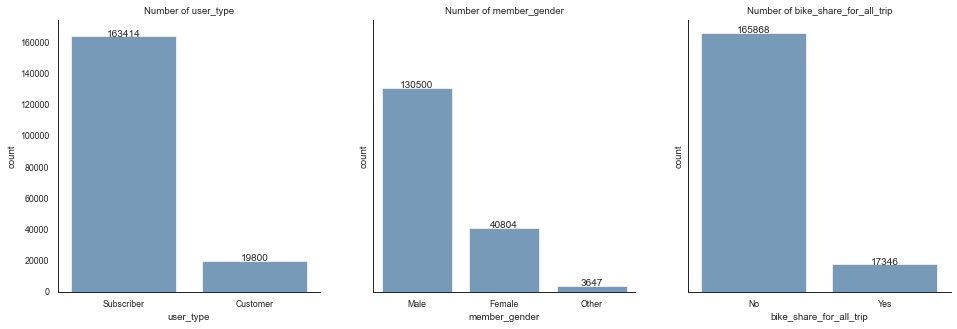

In [70]:
# user segmentation:
# user_type, member_gender, bike_share_for_all_trip,
sb.set_style()
# sb.despine()

fig, axes = plt.subplots(1, 3, figsize = (16, 5), sharey=True)
c = ['user_type', 'member_gender', 'bike_share_for_all_trip']
for i, user_seg in enumerate(c):
    sb.countplot(data = gb, 
                 x = user_seg, 
                 ax=axes[i], 
                 order = gb[user_seg].value_counts().index, 
                 alpha = 0.8, color = 'steelblue')
    for d, p in enumerate(axes[i].patches):
        height = p.get_height()
        axes[i].text(p.get_x()+p.get_width()/2., height + 0.1, gb[user_seg].value_counts()[d],ha="center")
    
    axes[i].set_title('Number of {}'.format(user_seg))
    axes[i].set_xlabel(user_seg)
    sb.despine()

# plt.savefig('pic/uni1.png')

 

It is tricky to look at user segmentation, since we dont have user id. All the user information is based on the rides, which leads bias due the same user having multiple rides. Therefore all the insights about user segmentation in this pics is based on the total number of rides. We could say among certain 183214 of rides, 163414 rides are made by Subscribers and 19800 made by Customers, which means almost 90% ride were taken by subscribers, in other words, almost 9 out of 10 rides are part of a subscription package. However, it is not saying the actual ratio of between subscriber and casual rider, since the subscriber VS Casual rider ratio should be $\frac{\text{# of subscriber user_id}}{\text{# of casual user_id}}$<br> As for member gender, despite 8263 rides not containing information of user gender, 130500 rides out of 174951 were taken by males, and 40804 rides are taken by female (Only one in hour ride taken by female). It is fair to assume that the male VS female ratio is not close as well as female are more concerned about cosmetic side-effect and mess-up hair during riding. And for Bike Share for All program for low-income residents, there are 17346 out of 183214, around 9% rides are part of bike share for all program. 

In [71]:
temp2 = gb.groupby(['age_group', 'member_gender']).size().to_frame('size').reset_index()
temp2 = temp2.pivot(index = 'age_group', columns = 'member_gender', values = 'size')

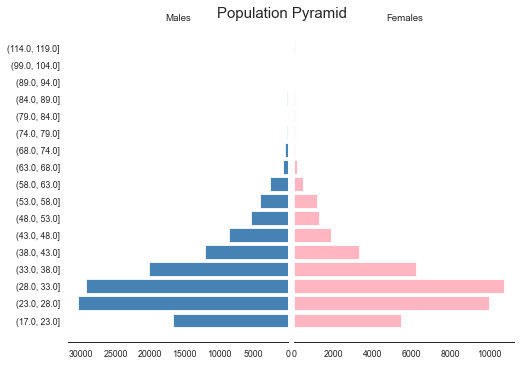

In [72]:
#define x and y limits
y = range(0, len(temp2))
x_male = temp2['Male']
x_female = temp2['Female']

#define plot parameters
fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(8, 6))

#specify background color and plot title
plt.figtext(.5,.9,"Population Pyramid ", fontsize=15, ha='center')
    
#define male and female bars
axes[0].barh(y, x_male, align='center', color='steelblue')
axes[0].set(title='Males')
axes[1].barh(y, x_female, align='center', color='lightpink')
axes[1].set(title='Females')

#adjust grid parameters and specify labels for y-axis
#axes[1].grid()
axes[0].set(yticks=y, yticklabels=temp2.index)
axes[0].invert_xaxis()
#axes[0].grid()

#display plot
plt.subplots_adjust(bottom=0.15, wspace=0.03)
sb.despine(left = True)


# plt.savefig('pic/uni2.png')

Now we create a poplution pyramid showing the age and gender distriburion of given rides. It is useful to understand the composition of a population and help us see the growth trend. As for gender, we already tell male users is much larger than female users, which show us the potential growth among female. Maybe it is worthy to start marketing campaign to encourage female users. Not surprisingly, the main user are 17 year ago to 40 year ago; which seems like the bike sharing idea is more popular during the younger. However, surprisingly, these were some senior users who ages over 80s. If we treated senior riders as outliers, we could clean data later.


In [73]:
def bar_plot(feature):
    temp1 = gb[feature].value_counts().sort_index()
    x = np.arange(len(temp1.index))
    g = sb.barplot(x = temp1.index, 
                  y = temp1.values,
                  alpha = 0.8,
                  color = 'steelblue')
    for d, p in enumerate(g.patches):
        height = p.get_height()
        g.text(p.get_x() + p.get_width()/2., height + 0.1, temp1[d], ha='center', size = 7)
    g.set_xticks(x)
    g.set_xticklabels(temp1.index)
    g.set_title('Number of Rides by {}'.format(feature))
    g.set_xlabel('{}'.format(feature))
    sb.despine()

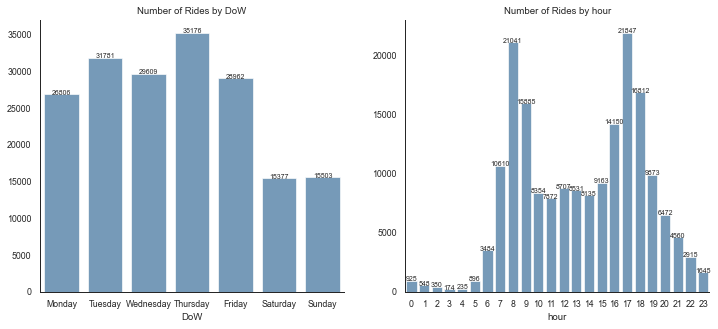

In [74]:
plt.figure(figsize = (12, 5))
plt.subplot(1,2,1)
axes[0] = bar_plot('DoW')
plt.xticks(np.arange(7), ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'))
plt.subplot(1,2,2)
axes[1] = bar_plot('hour')

# plt.savefig('pic/uni3.png')

We look at the trip counts over 2 dimensions, day of week and hour of day. I plot the number of rides over day of week and we could tell that the number of trips on weekdays is around double than the number over the weekends. It seems like that more need to ride short commute or fulfill the last mile to their offices or destinations on weekdays.
And for hour of day, we could tell the two peaks around 8 o'clock and 17 o'clock, which indicates that the large needs around the morning and evening rush hour. 

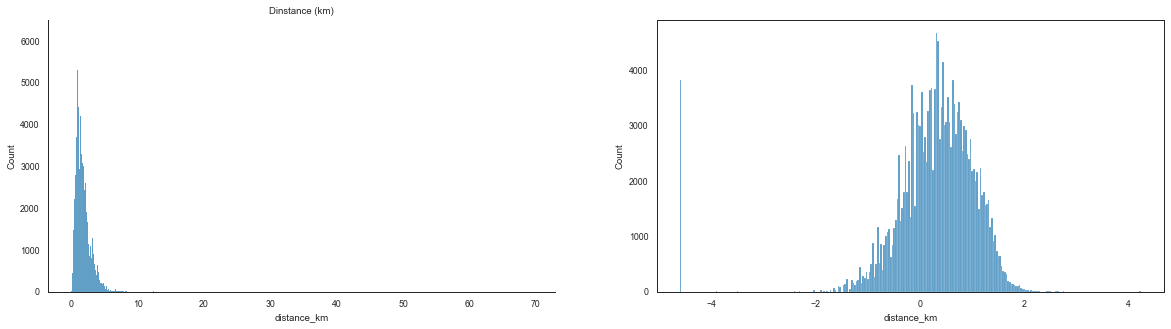

In [75]:
plt.figure(figsize = [20, 5])
plt.subplot(1,2,1)
sb.histplot(gb['distance_km'])
plt.title('Dinstance (km)')
sb.despine()

plt.subplot(1,2,2)
# log10 normalization
sb.histplot(np.log(gb.distance_km + 0.01))
# plt.savefig('pic/uni4.png')

These is no such feature representing the trip distance, I calculate the trip distances via start station coordinates and end station coordinates. The distribution is really right skewed, so when I tries to scale the data with log 10 transformation, issue raised. There are 3822 rides with 0 distance, which does not mean it did not move but shows the bikes got returned at the same station after a ride. (eg, taking a bike in front of a station near the office building to pick up a coffee during break and back to the same station) Therefore 0 distance make sence, but it causes problems to use log transformation since 0 will return negative infinite after log. Therefore, I am trying $\log(x+0.01)$ transformation to normalize the distance data. The right plot shows a peak around -4.605 representing the 0 distance rides. 

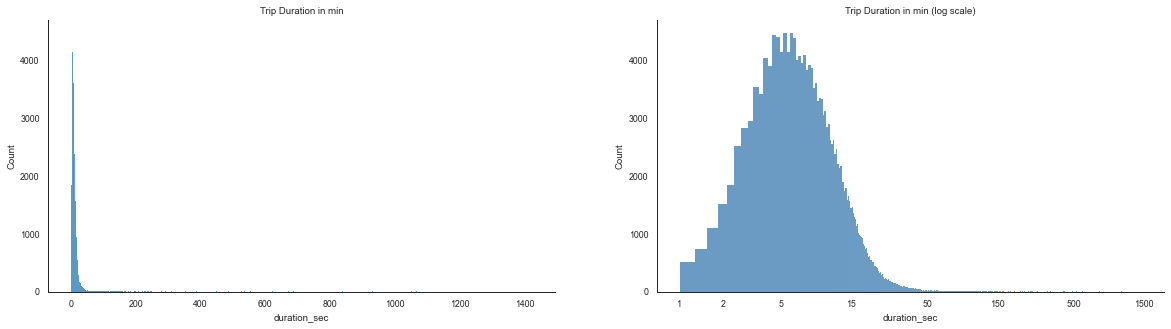

In [76]:
plt.figure(figsize = [20, 5])
plt.subplot(1,2,1)
sb.histplot(gb.duration_sec/60)
plt.title('Trip Duration in min')
sb.despine()

plt.subplot(1,2,2)
# Log10 normalization
bins = len(10**np.arange(1, 5+0.01, 0.01))
ticks = [1, 2, 5, 15, 50, 150, 500,1500]
labels = [v for v in ticks ]
sb.histplot(gb.duration_sec/60, alpha = 0.8, color = 'steelblue');
#g.set_xlabel('log')
plt.xscale('log')
plt.xticks(ticks, labels)
plt.title('Trip Duration in min (log scale)')
sb.despine()
#g.set_xlim(0, 5000)

# plt.savefig('pic/uni5.png')




Then we plot a histogram on trip duration in min. The left plot shows the data is really right skewed. Therefore, I apply log 10 transformation to the data, and plot it on the right. The right plot seems more normal distribution with slight long right tail. We could tell from the plot, the most rides lasted between 1 min to 50 min. Suprisingly, These are some long bike rides over 1 hour. 

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> Investigating distributions of individual variables, I looked at users segmentation, population phyramid, trip count over time, trip duration, and trip distance. There are some unusual points I found during univariate exploration. <br>
  The oldest user is over 100 year ago, the longest trip duration is around 24 hours and the shortest trip distance is zero. Of course, we could find reasonal explanation for all these unusual points, there are not impossible so I did keep those rides but delete only one record which user age is greater than 120. <br>
  For trip duration and trip distance, I apply different transformations to normalize the data. And after scaling data, the data tends to be more likely the normal distribution. 

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> In order to create the plots I mentioned above, I did some feature engineerin to create some new features, such as `duration_min` (divding `duration_sec` by 60),`age` (by `member_birth_year`),  `age_group` (make cut points for `age`), `DoW` (extrect week of day by `start_time`), `hour` (extract hour by `start_time`) and `distance_km` (calculating the distances between start station coordinates and end station coordinates)<br>
  I only delete one records due the over age (141-year-ago seems like a inaccurate input).

<a id='5'></a>
## Bivariate Exploration
Two factors interacting with each other

Text(0.5, 1.0, 'subscriber')

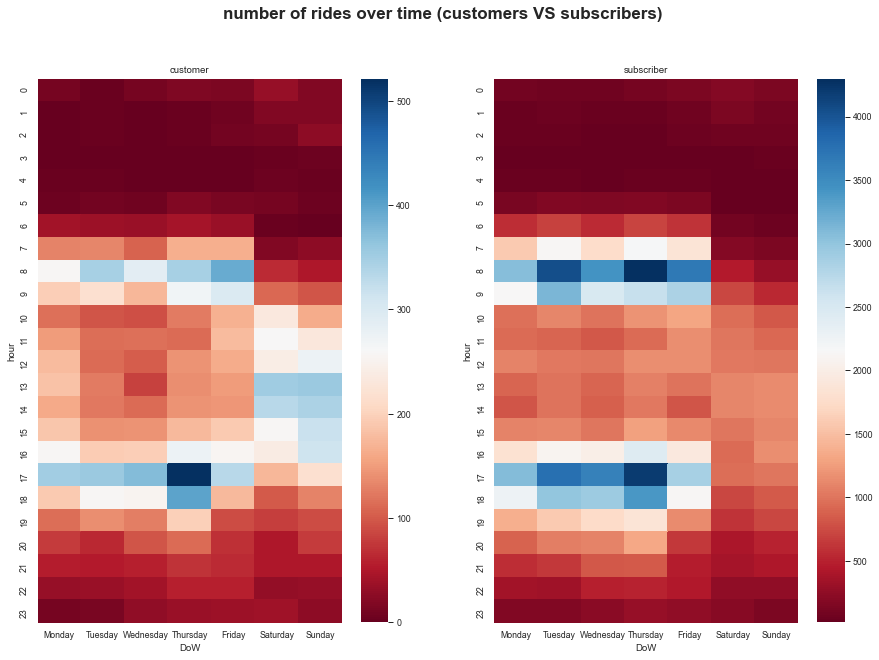

In [77]:
temp3_cus = gb[gb.user_type == 'Customer'].groupby(['DoW', 'hour']).size().to_frame('size').reset_index()
temp3_cus = temp3_cus.pivot(index = 'hour', columns = 'DoW', values = 'size').fillna(0)

temp3_sub = gb[gb.user_type == 'Subscriber'].groupby(['DoW', 'hour']).size().to_frame('size').reset_index()
temp3_sub = temp3_sub.pivot(index = 'hour', columns = 'DoW', values = 'size').fillna(0)

plt.figure(figsize = (15, 10))
plt.suptitle('number of rides over time (customers VS subscribers)', 
             fontsize = 17, 
             fontweight = 'bold')
plt.subplot(1,2,1)
sb.heatmap(temp3_cus, cmap='RdBu');
plt.xticks(np.arange(0.5, 7.5), 
           ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'))
plt.title('customer')

plt.subplot(1,2,2)
sb.heatmap(temp3_sub, cmap='RdBu');
plt.xticks(np.arange(0.5, 7.5), 
           ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'))
plt.title('subscriber')

# plt.savefig('pic/bi1.png')

I plot heatmaps, the heatmaps are capturing the number of rides over hour of day and day of week. When we look at the subscriber plot (right plot), there is a clear trajectory of rides taken by subscribers over time, which is that subscribers are taking rides on morning and evening rush hour on weekday. And the left plot is only for customers, same as the subscribers, customers take rides for weekday commuting. and interestingly, customers also have more need on weekend, which indicated that rids taken by customers on weekend may not be pre-scheduled. 

In [78]:
temp4_dis = gb.groupby(['age'])['distance_km'].mean().to_frame('mean').reset_index()
temp4_dur = gb.groupby(['age'])['duration_sec'].mean().to_frame('mean').reset_index()

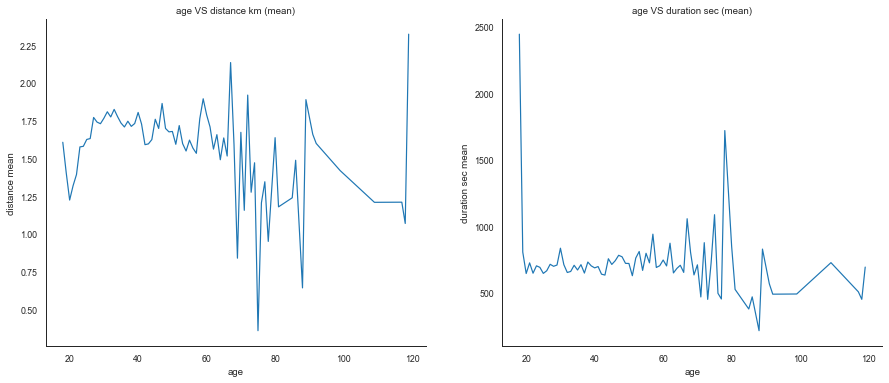

In [79]:
plt.figure(figsize = (15, 6))
plt.subplot(1,2,1)
sb.lineplot(x = 'age', y='mean',  data=temp4_dis);
plt.ylabel('distance mean')
plt.title('age VS distance km (mean)')
sb.despine()

plt.subplot(1,2,2)
sb.lineplot(x = 'age', y='mean',  data=temp4_dur);
plt.ylabel('duration sec mean')
plt.title('age VS duration sec (mean)')
sb.despine()

# plt.savefig('pic/bi2.png')

I draw two line plots. The left plot is age vs average trip distance and the right plot is age VS average trip duration. Between 20 year age and 60 year ago, the average distance is relatively stable, and after 60 year ago, the trip distance and trip duration have large variance. 


### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> I plot 4 plots for bivariate exploration. The first insight I drawed from the heatmaps focusing different user type (subscribers vs consumers), how they behave differently weekly? 
We could tell subscribers and customers did behave differently on weekend, customers rides seems show more needs on the weekend. It is a sign that a marketing campaign focus on promoting sharing bike on weekend event. <br> Secondly, from the lineplots, we learn about how age affect average trip distance and trip duration. 


### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> From the geo analysis we did at the first part, we could see the three cluster on the map, San Francisco, Oakland, San Jose. It is also interesting to look at different cities.


<a id='6'></a>
## Multivariate Exploration
Multivariate factores interacting with each other.

<Figure size 2160x720 with 0 Axes>

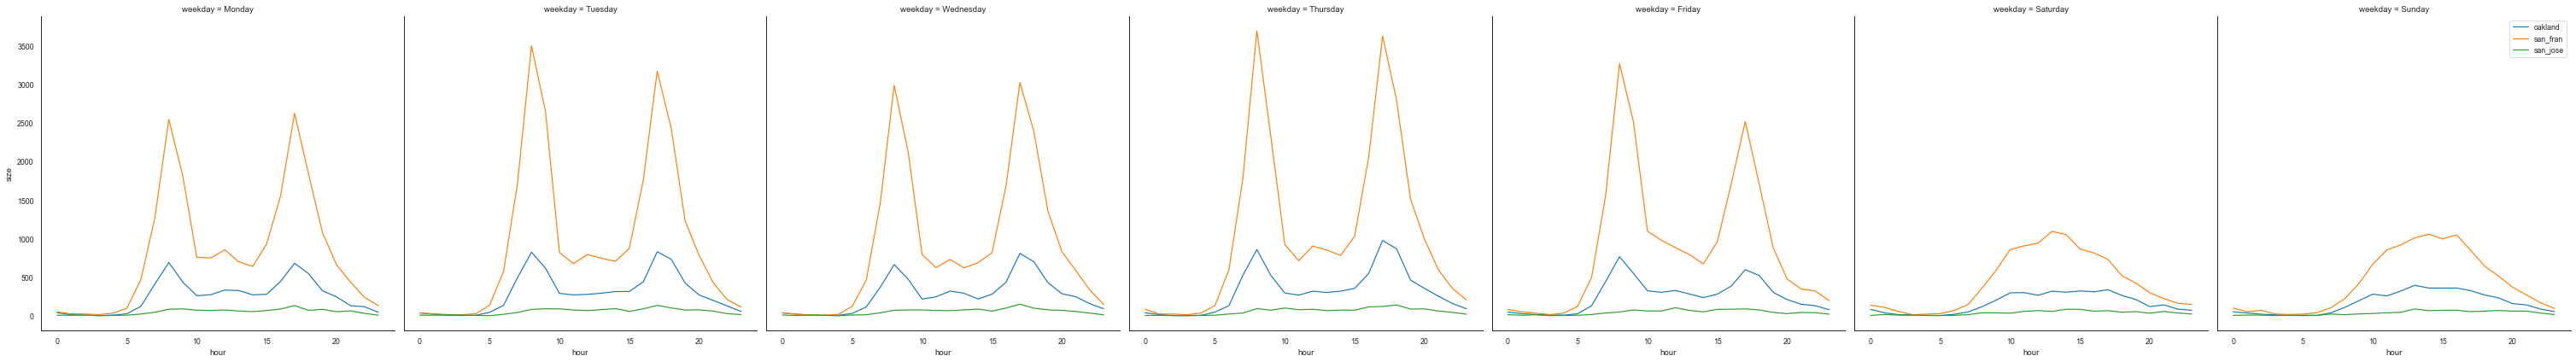

In [80]:
plt.figure(figsize = (30, 10))
temp6 = gb.groupby(['city', 'hour', 'DoW']).size().to_frame('size').reset_index()
dayOfWeek={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
temp6['weekday'] = temp6['DoW'].map(dayOfWeek)
col_order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
sb.set_style("white")
ax = sb.FacetGrid(temp6, col="weekday", col_wrap=7, height=6, col_order=col_order, hue = 'city');
ax.map(sb.lineplot, "hour", "size");
plt.legend()

# plt.savefig('pic/multi1.png')

When Adding the cities (San Francisco, San Jose, Oakland) into the number of rides over time, We could tell all three cities shows the similar trends, a high volume on weekday commute rush hour and weekend afternoon. Among the cities, San Francisco has the highest sharing bike needs, and followed by Oakland and then San Jose.



In [81]:
temp7_sub = gb[gb.user_type == 'Subscriber']\
.groupby(['age_group', 'member_gender'])['distance_km']\
.mean().to_frame('mean').reset_index()

temp7_cus = gb[gb.user_type == 'Customer']\
.groupby(['age_group', 'member_gender'])['distance_km']\
.mean().to_frame('mean').reset_index()

temp8_sub = gb[gb.user_type == 'Subscriber']\
.groupby(['age_group', 'member_gender'])['duration_sec']\
.mean().to_frame('mean').reset_index()

temp8_cus = gb[gb.user_type == 'Customer']\
.groupby(['age_group', 'member_gender'])['duration_sec']\
.mean().to_frame('mean').reset_index()

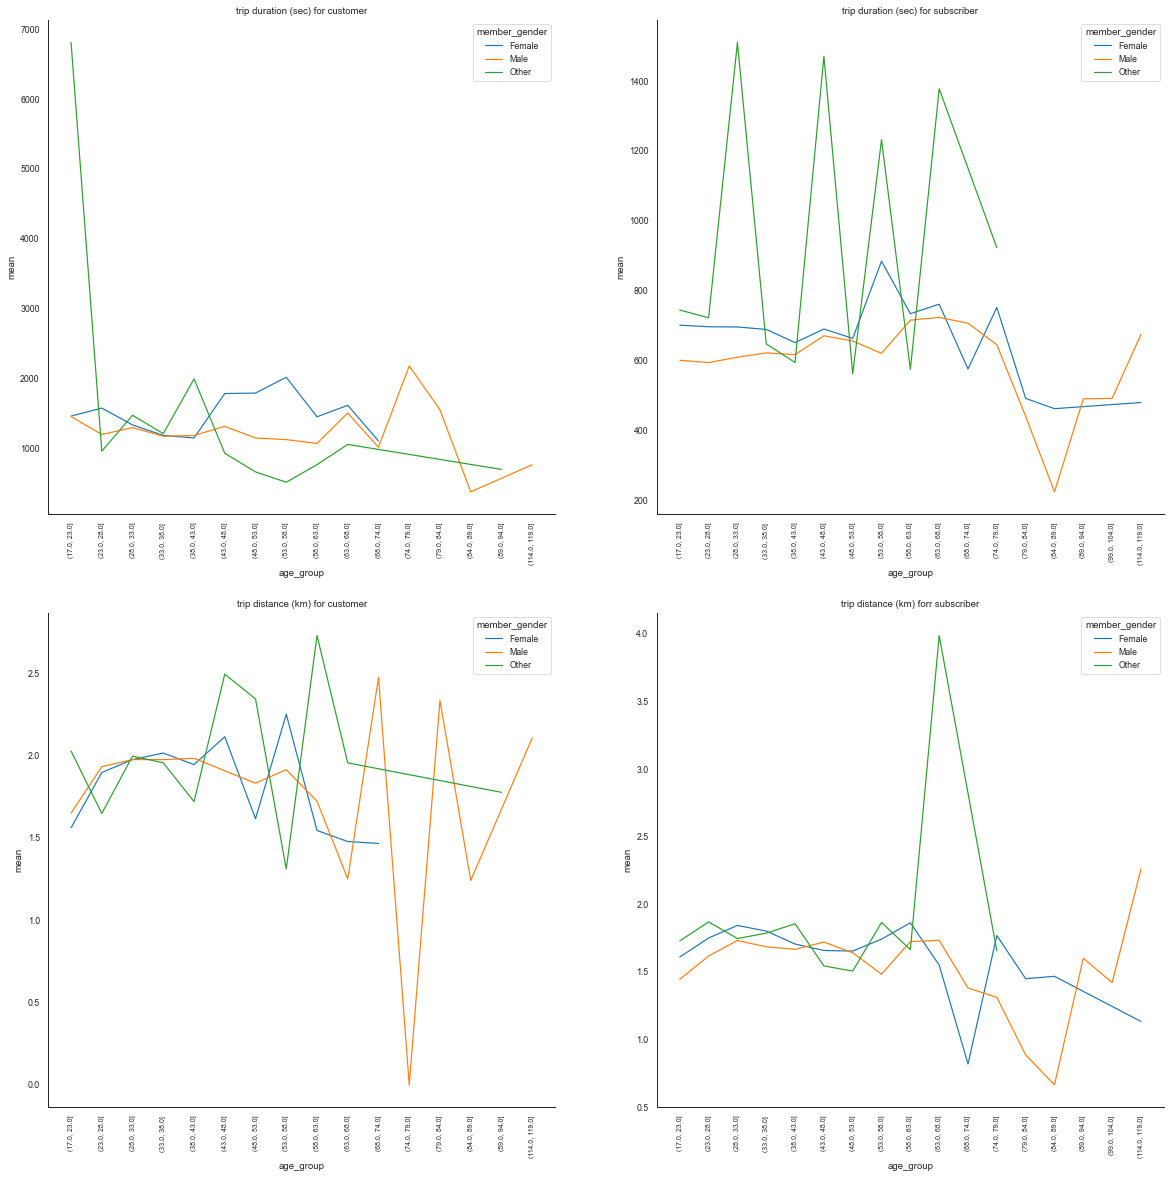

In [82]:
plt.figure(figsize = (20, 20))

plt.subplot(2,2,1)
sb.lineplot(x = temp8_cus['age_group'].astype(str), y='mean', hue = 'member_gender', data = temp8_cus)
plt.xticks(rotation = 90, fontsize = 7)
plt.title('trip duration (sec) for customer')
sb.despine()

plt.subplot(2,2,2)
sb.lineplot(x = temp8_sub['age_group'].astype(str), y='mean', hue = 'member_gender', data = temp8_sub)
plt.xticks(rotation = 90, fontsize = 7)
plt.title('trip duration (sec) for subscriber')
sb.despine()

plt.subplot(2,2,3)
sb.lineplot(x = temp7_cus['age_group'].astype(str), y='mean', hue = 'member_gender', data = temp7_cus)
plt.xticks(rotation = 90, fontsize = 7)
plt.title('trip distance (km) for customer')
sb.despine()

plt.subplot(2,2,4)
sb.lineplot(x = temp7_sub['age_group'].astype(str), y='mean', hue = 'member_gender', data = temp7_sub)
plt.xticks(rotation = 90, fontsize = 7)
plt.title('trip distance (km) forr subscriber')
sb.despine()

#plt.savefig('pic/multi2.png')


For all four plots, it is suspicious that the member gender of other shows some usual thing for all plots. It is worthy to investigate it if we have more data. Besides, overall subscribers is generally taking rides with more distance and more duration. And there is no significant difference between male and female regarding average trip duration and average trip duration.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> Just like our univariate exploratoin and bivariate exploration, for user segmention, user type makes a critical influence between customers and subscribers. And for time series, the time (day and hour) is a important key to the number of trip, locatoin and path. 

### Were there any interesting or surprising interactions between features?

> When we take city into account, appealingly all cities beahev differently, it is worthy to take look at three cities separately in the future to understand how user in different cities engage bike sharing. 

> At the end of your report, make sure that you export the notebook as an
html file from the `File > Download as... > HTML` menu. Make sure you keep
track of where the exported file goes, so you can put it in the same folder
as this notebook for project submission. Also, make sure you remove all of
the quote-formatted guide notes like this one before you finish your report!